In [47]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
import shutil
import json

In [48]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [49]:
import pickle
with open('./iou_with_id_scores_sorted_all_valid_preproc.pkl', 'rb') as f:
  iou_with_id_scores_sorted = pickle.load(f)

In [106]:
tgt_ids_low_scores = [x[0] for x in iou_with_id_scores_sorted[:20]]
tgt_ids_high_scores = [x[0] for x in iou_with_id_scores_sorted[-20:]]

In [107]:
df = pd.read_csv('./tile_meta.csv')
eval_ids = tgt_ids_high_scores
print(len(eval_ids))
if os.path.exists('./all_eval_imgs'):
  shutil.rmtree('./all_eval_imgs')
if os.path.exists('./all_eval_masks'):
  shutil.rmtree('./all_eval_masks')
os.mkdir('./all_eval_imgs')
os.mkdir('./all_eval_masks')
for f in os.listdir('full_training_data/all_valid_imgs'):
  if f.split('.')[0] in eval_ids:
    shutil.copy(f'full_training_data/all_valid_imgs/{f}', f'./all_eval_imgs/{f}')
    shutil.copy(f'full_training_data/all_valid_masks/{f}', f'./all_eval_masks/{f}')

20


In [108]:
DATA_DIR = './'
# x_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_imgs')
# y_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_masks')
x_test_dir = os.path.join(DATA_DIR, 'all_eval_imgs')
y_test_dir = os.path.join(DATA_DIR, 'all_eval_masks')

In [109]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [110]:
class HubMapDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'blood_vessel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return self.images_fps[i], image, mask
        
    def __len__(self):
        return len(self.ids)

In [111]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=352, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=352, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [112]:
# Inference
DEVICE = 'cpu'
best_model = torch.load('./models/best_model.pth', map_location=torch.device('cpu'))
best_model = best_model.to(DEVICE)

In [113]:
CLASSES = ['blood_vessel']
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

In [114]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [115]:
CLASSES = ['blood_vessel']
test_dataset_vis = HubMapDataset(
    x_test_dir, 
    y_test_dir,
    classes=CLASSES,
)
test_dataset = HubMapDataset(
    x_test_dir, 
    y_test_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_loader = DataLoader(test_dataset)

In [116]:
len(test_dataset)

20

In [117]:
import cv2
import numpy as np
import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def extract_polygon_masks(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    masks = []
    
    for contour in contours:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if approx.shape[0] >= 3:
            polygon_mask = np.zeros_like(mask)
            cv2.drawContours(polygon_mask, [approx], 0, 1, -1)
            masks.append(polygon_mask.astype('bool'))
    
    return masks

def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != np.bool_:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)
  
  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

def calculate_iou(target_polygon_masks, output_polygon_mask):
  max_iou_score = 0
  for target_polygon_mask in target_polygon_masks:
    intersection = np.logical_and(target_polygon_mask, output_polygon_mask).sum()
    union = np.logical_or(target_polygon_mask, output_polygon_mask).sum()
    iou_score = float(intersection)/union
    max_iou_score = max(max_iou_score, iou_score)
  return max_iou_score

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


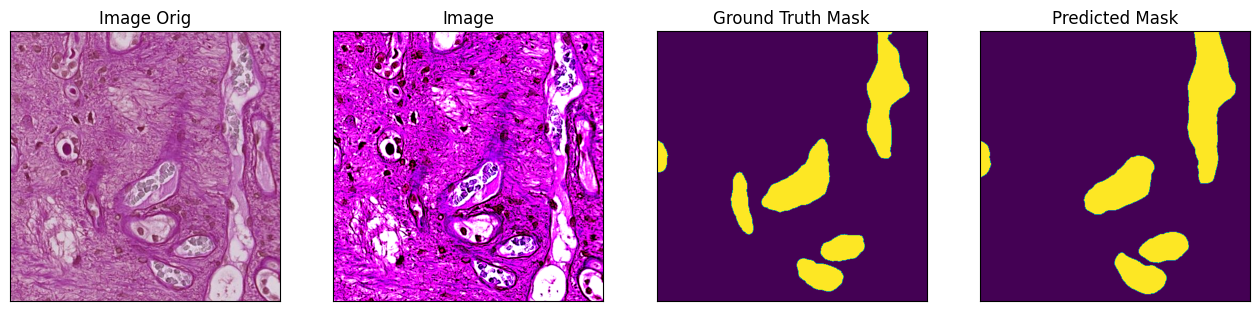

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


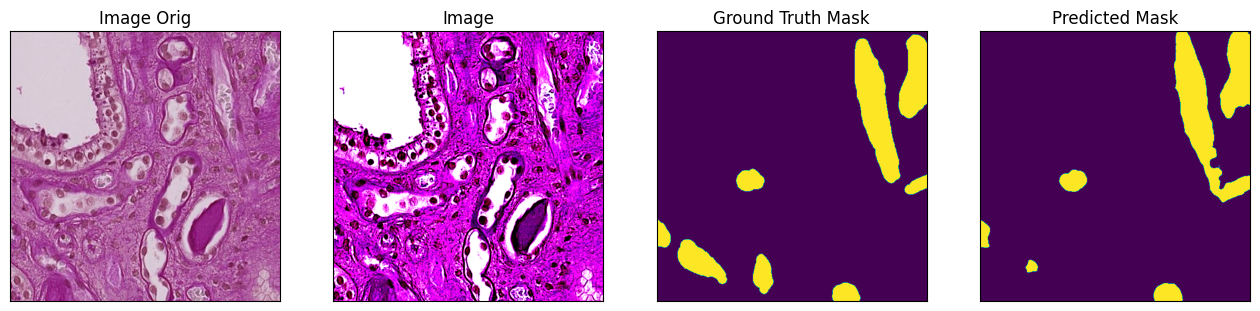

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


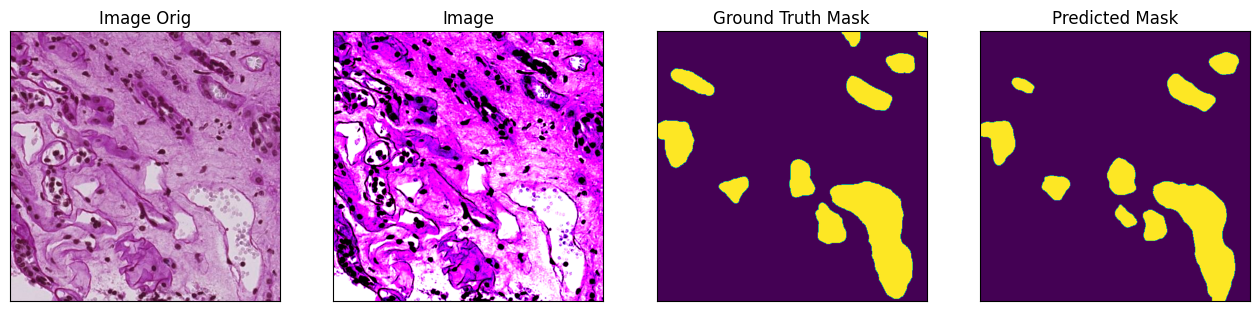

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


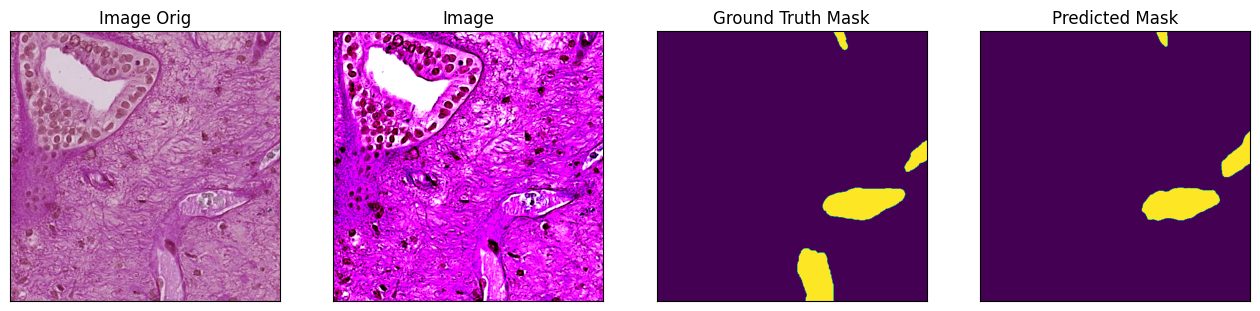

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


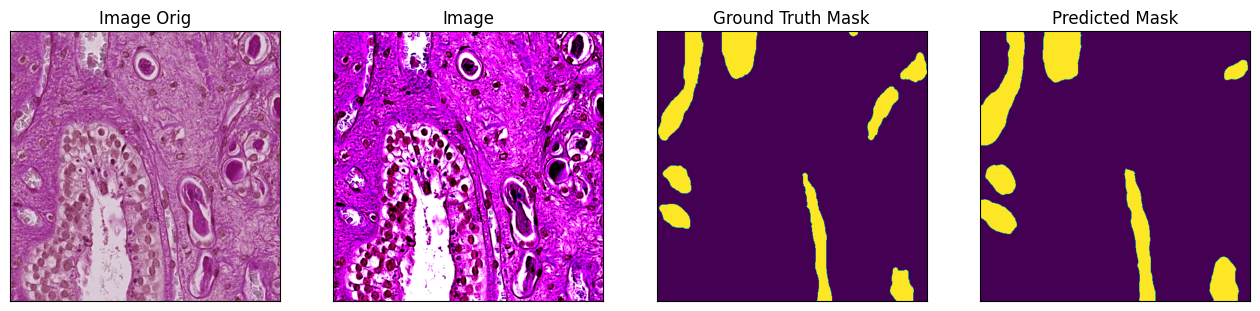

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


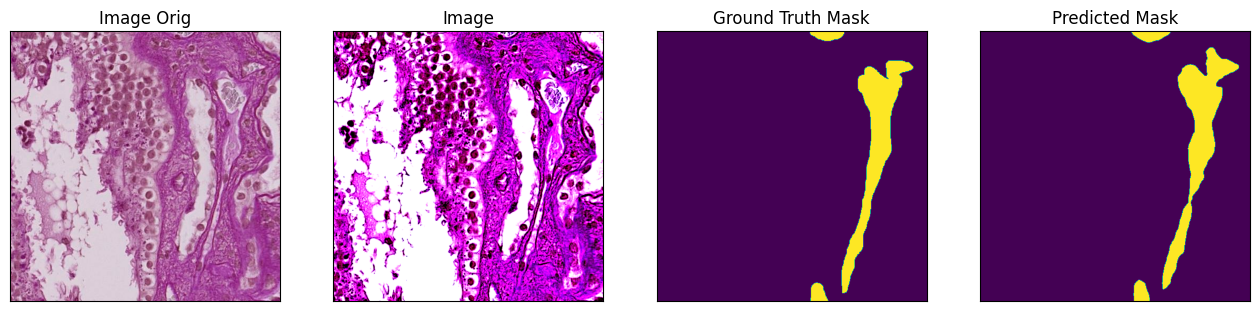

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


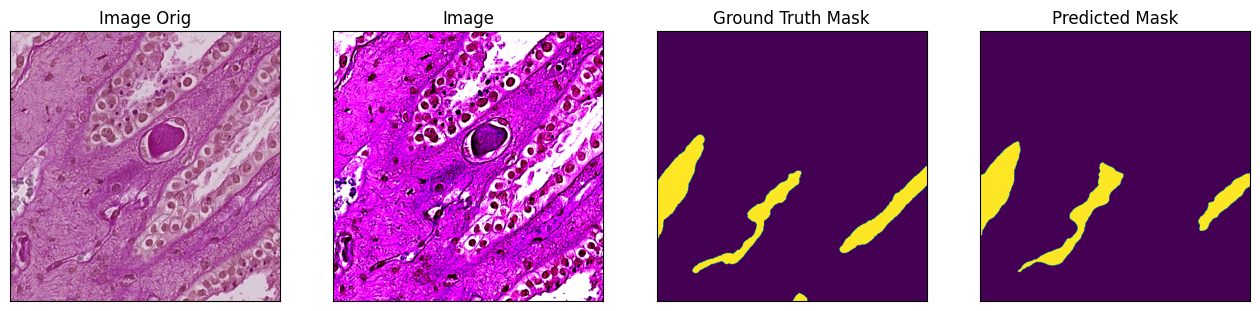

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


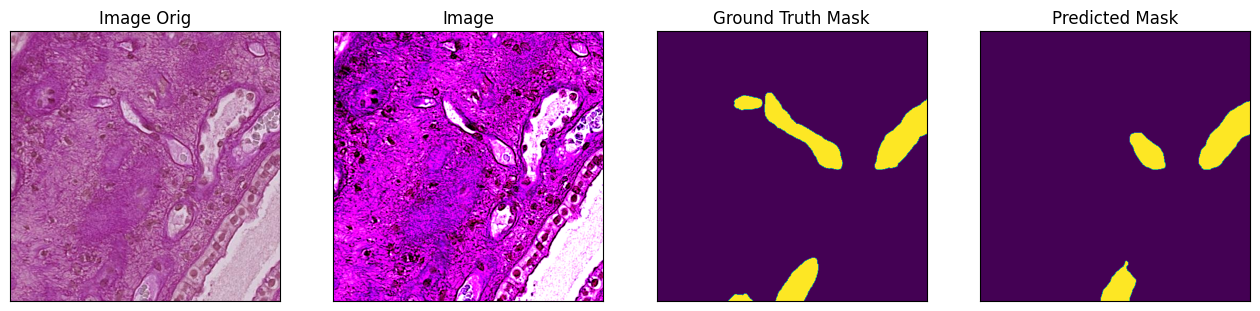

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


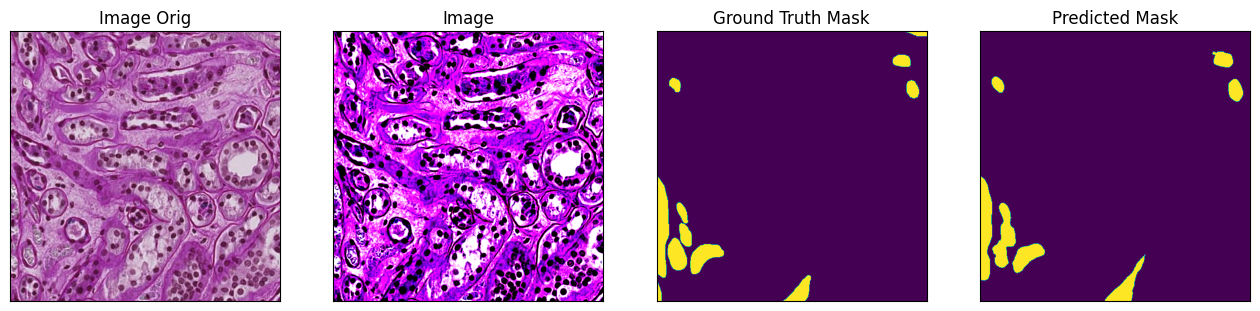

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


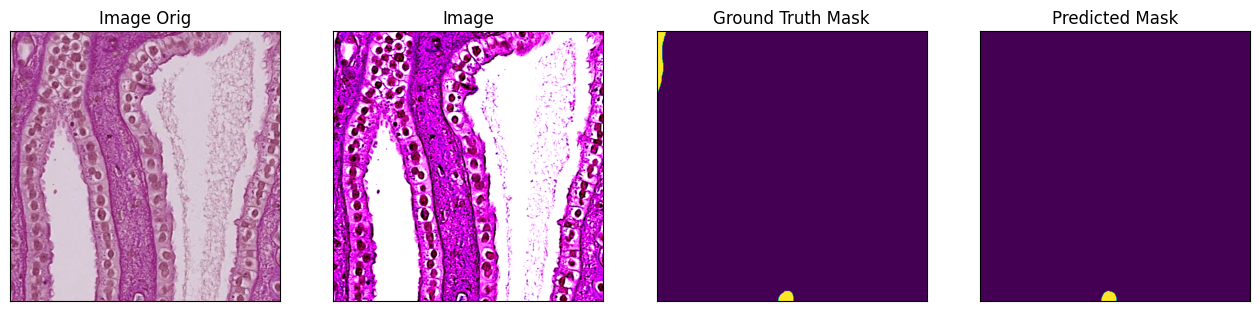

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 512, 512])
(512, 512)


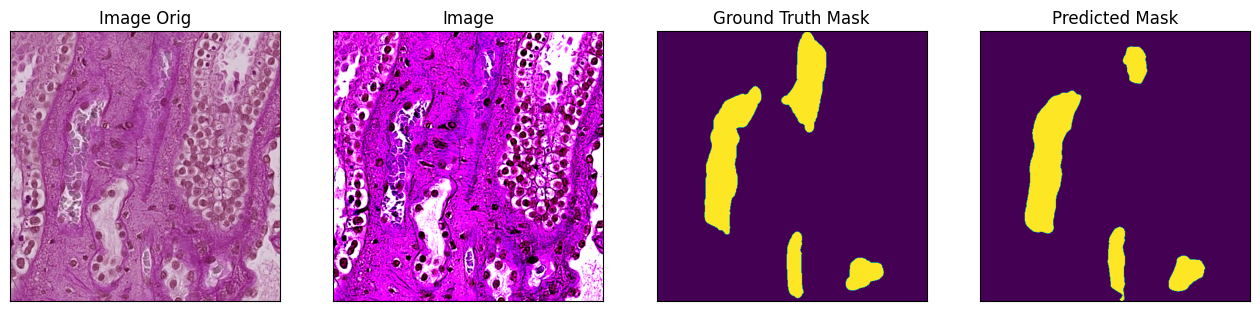

image tran shape: (512, 512, 3)
(3, 512, 512) (1, 512, 512)
torch.Size([1, 3, 512, 512])


In [ ]:
for i in range(len(test_dataset)):
    image_vis = test_dataset_vis[i][1].astype('uint8')
    _, image, gt_mask = test_dataset[i]
    image_trans = image.transpose(1,2,0)
    print(f'image tran shape: {image_trans.shape}')
    print(image.shape, gt_mask.shape)
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = torch.sigmoid(best_model.predict(x_tensor))
    print(pr_mask.shape)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print(pr_mask.shape)
    
    visualize(
        image_orig = image_vis,
        image=image_trans, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [85]:
len(test_dataset)

10